# Imbalance Data Scenario

Klasifikasi hasil citra USG payudara (*breast cancer*) menggunakan arsitektur ResNet152v2 dengan jumlah data asli (*imbalance*), jumlah epoch sebanyak 30.

# Preparing the Data

### Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = '/content/drive/MyDrive/Dataset/Breast Cancer Dataset'

In [4]:
base_dir = '/content/drive/MyDrive/Dataset/Breast Cancer Dataset/data'

#Menentukan direktori data training
train_dir = os.path.join(base_dir, 'train')

train_benign = train_dir+'/benign'
train_malignant = train_dir+'/malignant'
train_normal = train_dir+'/normal'

#Menentukan direktori data testing
test_dir = os.path.join(base_dir, 'test')

test_benign = test_dir+'/benign'
test_malignant =test_dir+'/malignant'
test_normal = test_dir+'/normal'

#Menghitung total data train
print('total citra train:', len(os.listdir(train_benign))+
                            len(os.listdir(train_malignant))+
                            len(os.listdir(train_normal))
                            )
#Menghitung total data test
print('total citra test:', len(os.listdir(test_benign))+
                           len(os.listdir(test_malignant))+
                           len(os.listdir(test_normal)))

total citra train: 689
total citra test: 78


### Resize image

In [5]:
image_height = image_width = 224
batch_size = 16

In [6]:
data_train = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(image_height, image_width)
  )

Found 689 files belonging to 3 classes.


In [7]:
class_names = data_train.class_names
print(class_names)

['benign', 'malignant', 'normal']


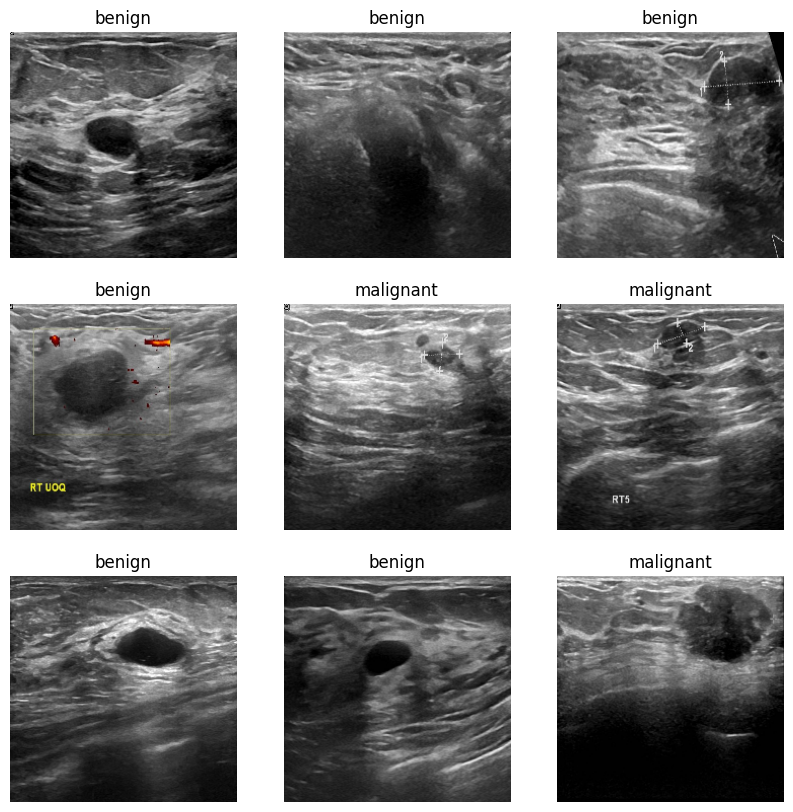

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
data_test = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(image_height, image_width)
  )

Found 78 files belonging to 3 classes.


In [10]:
class_names = data_test.class_names
print(class_names)

['benign', 'malignant', 'normal']


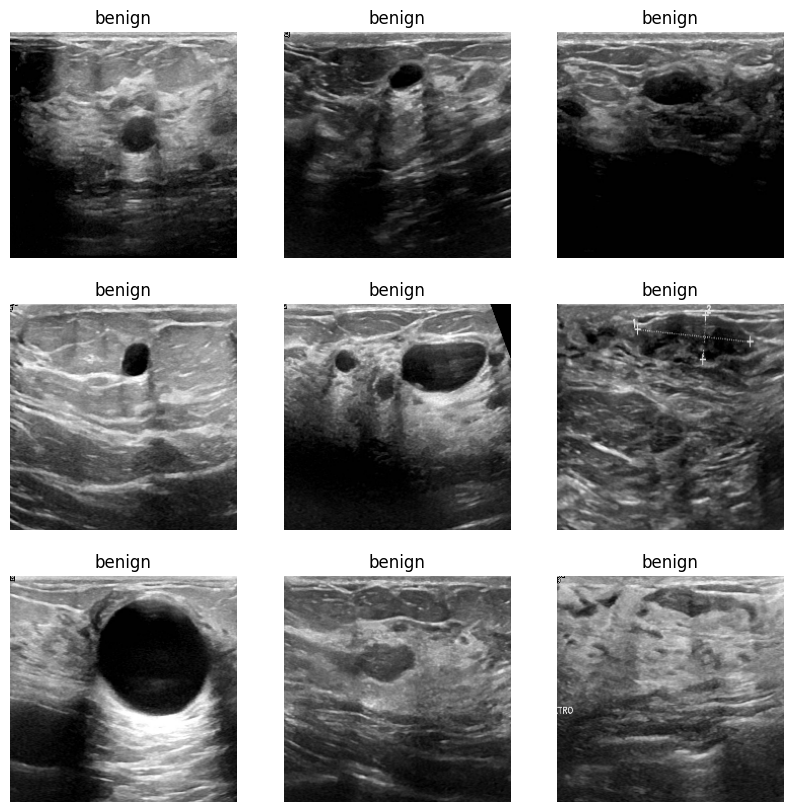

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in data_test.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Augmentasi Data

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 10,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.4,1.5],
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest',
                                   validation_split=0.15
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255,
                                        validation_split=0.15
                                        )
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    subset='training',
    seed = 123,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    subset='validation',
    seed = 123,
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    seed = 123,
    shuffle = False
)

Found 587 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 78 images belonging to 3 classes.


In [14]:
from sklearn.utils import class_weight
import numpy as np
from sklearn.utils import compute_class_weight

train_classes = train_generator.classes
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_classes),
                                     y = train_classes
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 0.6039094650205762, 1: 1.215320910973085, 2: 1.9183006535947713}

## Perancangan Arsitektur CNN

In [15]:
from keras import regularizers
tf.keras.backend.clear_session()

from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.regularizers import L2

model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(image_height, image_width, 3))),
    Conv2D(512, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.layers[0].trainable = False
model.summary()

234545216/234545216 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 512)         9437696   
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 512)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               

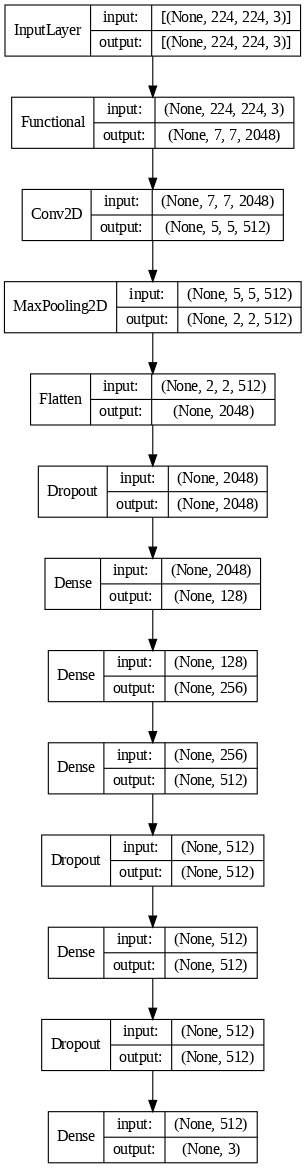

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80)

## Training Data

In [17]:
import keras

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=['accuracy', keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.SensitivityAtSpecificity(0.5)])

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

In [19]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [20]:
%%time
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[reduce_lr, lr_scheduler],
                    shuffle = True)

Epoch 1/30
37/37 [==============================] - 81s 2s/step - loss: 2.6403 - accuracy: 0.4838 - specificity_at_sensitivity: 0.7325 - sensitivity_at_specificity: 0.7564 - val_loss: 1.9385 - val_accuracy: 0.5980 - val_specificity_at_sensitivity: 0.8971 - val_sensitivity_at_specificity: 0.8333 - lr: 0.0010
Epoch 2/30
37/37 [==============================] - 20s 546ms/step - loss: 2.0659 - accuracy: 0.5366 - specificity_at_sensitivity: 0.8186 - sensitivity_at_specificity: 0.8228 - val_loss: 1.9184 - val_accuracy: 0.5980 - val_specificity_at_sensitivity: 0.8431 - val_sensitivity_at_specificity: 0.9020 - lr: 0.0010
Epoch 3/30
37/37 [==============================] - 17s 455ms/step - loss: 1.8937 - accuracy: 0.6235 - specificity_at_sensitivity: 0.8893 - sensitivity_at_specificity: 0.8705 - val_loss: 1.7601 - val_accuracy: 0.5980 - val_specificity_at_sensitivity: 0.9706 - val_sensitivity_at_specificity: 0.9706 - lr: 0.0010
Epoch 4/30
37/37 [==============================] - 18s 471ms/step 

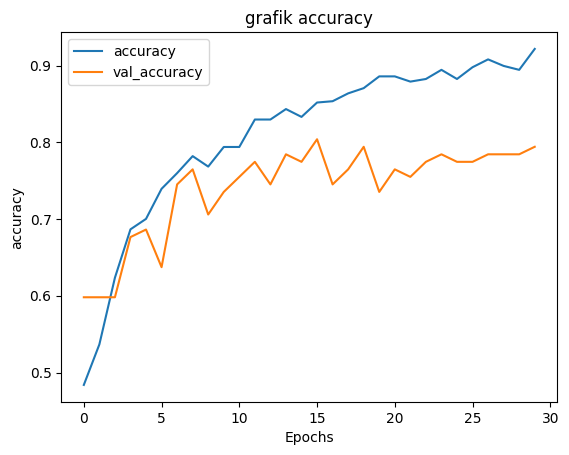

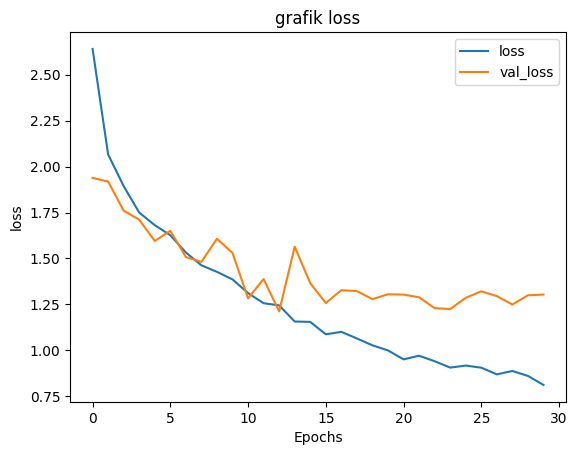

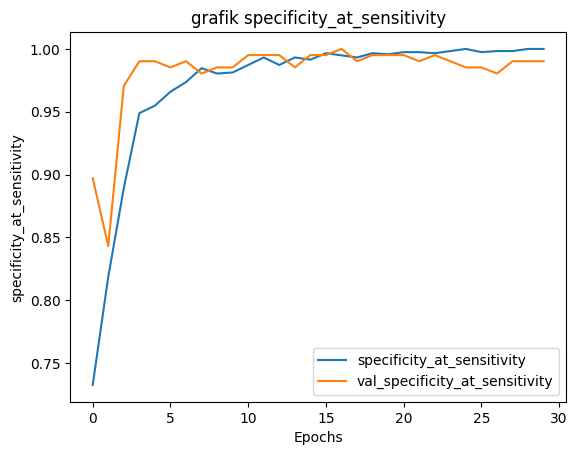

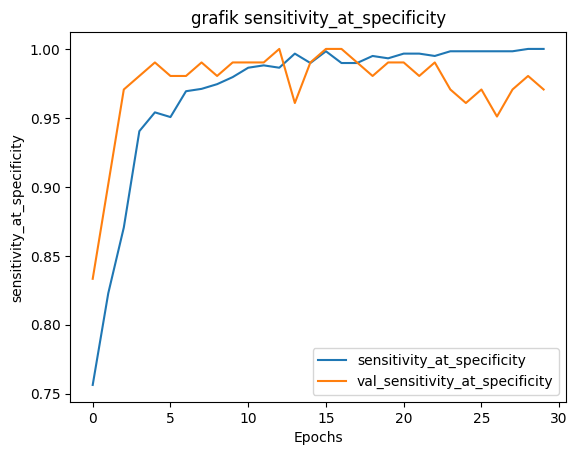

In [21]:
def grafik_plot(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title('grafik '+string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

grafik_plot(history, "accuracy")
grafik_plot(history, "loss")
grafik_plot(history, "specificity_at_sensitivity")
grafik_plot(history, "sensitivity_at_specificity")

## Testing Data

In [22]:
true_labels = test_generator.classes
prob_test = model.predict(test_generator)
predictions = prob_test.argmax(axis=1)

print('Label Sebenarnya : ', true_labels)
print('Label Prediksi : ', predictions)

test_model = model.evaluate(test_generator, verbose=1)

5/5 [==============================] - 5s 701ms/step
Label Sebenarnya :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]
Label Prediksi :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 2 2 2 2 2 2 2 0 2 2
 2 2 0 0]
5/5 [==============================] - 1s 193ms/step - loss: 0.8382 - accuracy: 0.8718 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000


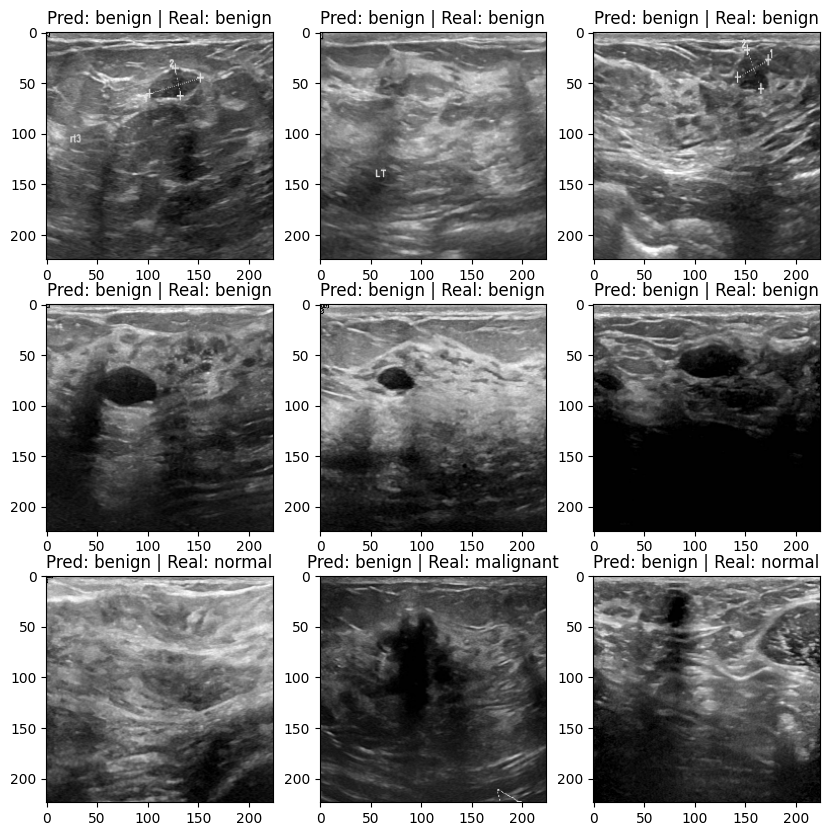

In [23]:
plt.figure(figsize=(10,10))
for images, labels in data_test.take(1):
  classifications = model(images)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = np.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [24]:
print(train_generator.class_indices)

{'benign': 0, 'malignant': 1, 'normal': 2}


In [25]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 224, 224, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  kelas = ['benign', 'malignant', 'normal']
  df['Kelas'] = kelas
  df = df[['Kelas', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_class = 'benign'
  elif predict_label == 1:
      predict_class = 'malignant'
  else:
      predict_class = 'normal'

  return predict_class, df

Saving benign (1).png to benign (1).png
1/1 [==============================] - 0s 33ms/step




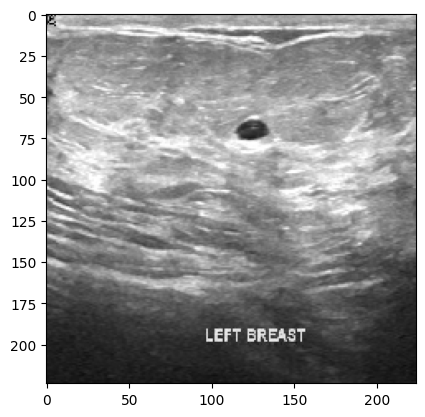


Citra dikenali sebagai benign


       Kelas   Probability
0     benign  1.000000e+00
1  malignant  2.471042e-12
2     normal  3.566052e-20




In [26]:
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nCitra dikenali sebagai " + label)
print('\n')
print(df)
print('\n')

## Evaluasi

In [27]:
# Evaluasi loss, akurasi, specificity, sensitivity pada train data

loss, accuracy, specificity, sensitivity = model.evaluate(train_generator)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

37/37 [==============================] - 16s 419ms/step - loss: 0.7653 - accuracy: 0.9404 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000
Loss train set:  0.7653005719184875
Akurasi train set:  0.9403747916221619
Specificity train set:  1.0
Sensitivity train set:  1.0


In [28]:
# Evaluasi loss, akurasi, specificity, sensitivity pada validation data

val_loss, val_accuracy, val_specificity, val_sensitivity = model.evaluate(validation_generator)
print('Loss validation set: ', val_loss)
print('Akurasi validation set: ', val_accuracy)
print('Specificity validation set: ', val_specificity)
print('Sensitivity validation set: ', val_sensitivity)

7/7 [==============================] - 1s 187ms/step - loss: 1.3035 - accuracy: 0.7941 - specificity_at_sensitivity: 0.9902 - sensitivity_at_specificity: 0.9706
Loss validation set:  1.3034619092941284
Akurasi validation set:  0.7941176295280457
Specificity validation set:  0.9901960492134094
Sensitivity validation set:  0.970588207244873


In [29]:
# Evaluasi loss, akurasi, specificity, sensitivity pada test data

test_loss, test_accuracy, test_specificity, test_sensitivity = model.evaluate(test_generator)
print('Loss test set: ', test_loss)
print('Akurasi test set: ', test_accuracy)
print('Specificity test set: ', test_specificity)
print('Sensitivity test set: ', test_sensitivity)

5/5 [==============================] - 1s 196ms/step - loss: 0.8382 - accuracy: 0.8718 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000
Loss test set:  0.8382142782211304
Akurasi test set:  0.8717948794364929
Specificity test set:  1.0
Sensitivity test set:  1.0


In [30]:
prediction= model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=2)
prediction= (prediction > 0.5)
val_labels=test_generator.classes

5/5 - 1s - 968ms/epoch - 194ms/step


In [31]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

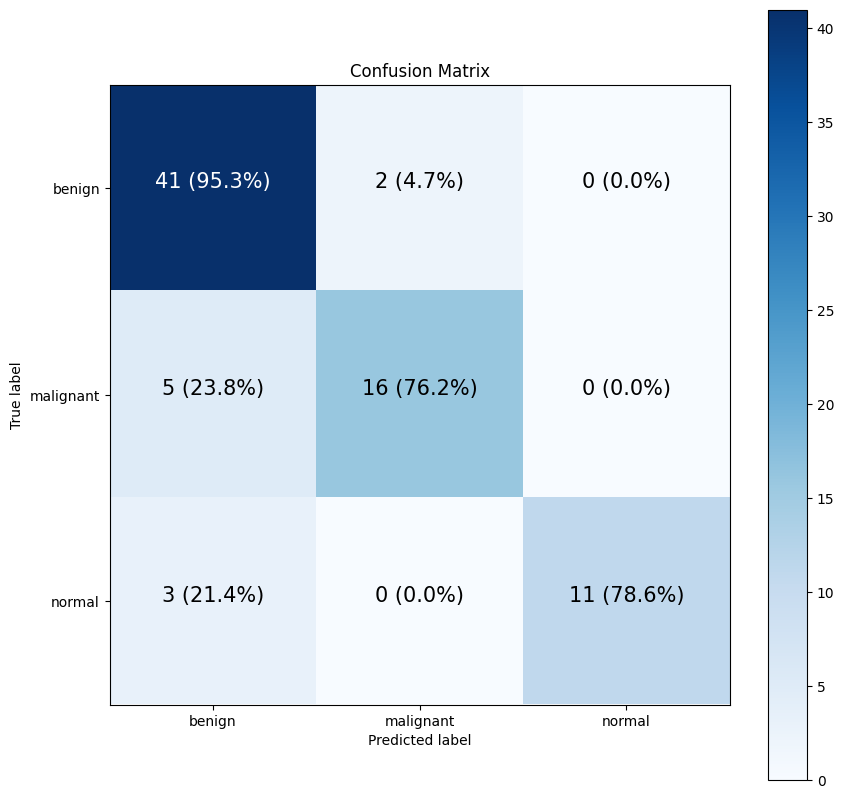

In [32]:
make_confusion_matrix(y_true=true_labels,
                      y_pred=predictions,
                      classes=test_generator.class_indices,
                      figsize=(10,10),
                      text_size=15)

In [33]:
from sklearn.metrics import classification_report

num_of_train_samples = 703
num_of_test_samples = 77
batch_size = 16

Y_pred = model.predict(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

5/5 [==============================] - 1s 193ms/step
Classification Report
              precision    recall  f1-score   support

      benign       0.84      0.95      0.89        43
   malignant       0.89      0.76      0.82        21
      normal       1.00      0.79      0.88        14

    accuracy                           0.87        78
   macro avg       0.91      0.83      0.86        78
weighted avg       0.88      0.87      0.87        78



5/5 [==============================] - 1s 222ms/step


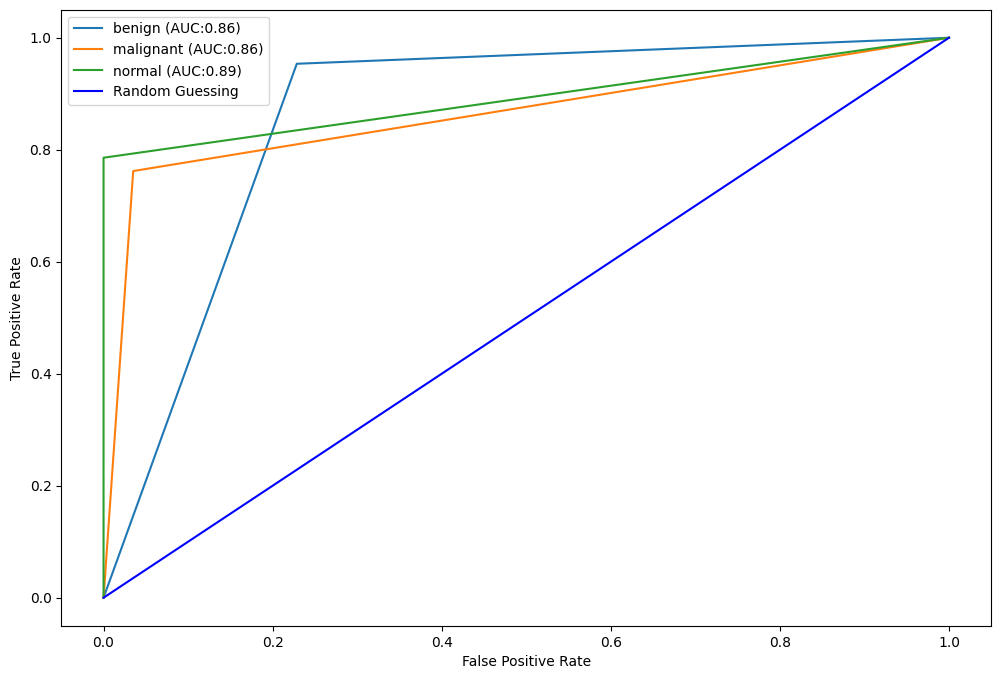

In [34]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

test_generator.reset()
y_pred = model.predict(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(test_generator.classes, y_pred)

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [35]:
model.save_weights('model_simple_weights_2.h5')
model.save('breast_cancer_imbalance.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
